# House Price Prediction in Bangalore, India

In [1]:
import pandas as pd
import numpy as np

from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium 

!pip install geocoder
import geocoder

import requests

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

!pip install category_encoders
import category_encoders as ce

from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor

!pip install xgboost
from xgboost import XGBRegressor

from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor

from sklearn import linear_model

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.8           |   py36h45558ae_2         628 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

In [2]:
# Foursquare Credentials 
client_id = '0GE21IKRH3FZODF1RNWDMLN1LUFENFD0EAYCZ3VXT4V4OMAE'
client_secret = '0EO1LG0JP10J3CN5HYFDCCZM3ACMDXPZWPBY1WXQBIQZHXAI'
version = '20201604'
limit = 100

In [3]:
# Get Banglore coordinates
address = "Banglore, India"

geolocator = Nominatim(user_agent="e_tgg")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print(address, "coordinates:", latitude, ",", longitude)

Banglore, India coordinates: 18.0056901 , 79.5715088


In [4]:
radius = 500

In [5]:
# Define URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    client_id, 
    client_secret, 
    latitude, 
    longitude, 
    version, 
    radius, 
    limit)
url

'https://api.foursquare.com/v2/venues/explore?client_id=0GE21IKRH3FZODF1RNWDMLN1LUFENFD0EAYCZ3VXT4V4OMAE&client_secret=0EO1LG0JP10J3CN5HYFDCCZM3ACMDXPZWPBY1WXQBIQZHXAI&ll=18.0056901,79.5715088&v=20201604&radius=500&limit=100'

In [6]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9e85b2f7706a001be7721d'},
 'response': {'headerLocation': 'Warangal',
  'headerFullLocation': 'Warangal',
  'headerLocationGranularity': 'city',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 18.010190104500005,
    'lng': 79.57623170275289},
   'sw': {'lat': 18.001190095499993, 'lng': 79.56678589724712}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea279897ee52a35dce92bf9',
       'name': 'Thousand Pillar Temple',
       'location': {'lat': 18.00426345496528,
        'lng': 79.57485226131779,
        'labeledLatLngs': [{'label': 'display',
          'lat': 18.00426345496528,
          'lng': 79.57485226131779}],
        'distance': 387,
        'cc': 'IN',
        'city': 'Hanamkonda',
        'state': 'Telangana',
 

In [7]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4ea279897ee52a35dce92bf9',
  'name': 'Thousand Pillar Temple',
  'location': {'lat': 18.00426345496528,
   'lng': 79.57485226131779,
   'labeledLatLngs': [{'label': 'display',
     'lat': 18.00426345496528,
     'lng': 79.57485226131779}],
   'distance': 387,
   'cc': 'IN',
   'city': 'Hanamkonda',
   'state': 'Telangana',
   'country': 'India',
   'formattedAddress': ['Hanamkonda', 'Telangana', 'India']},
  'categories': [{'id': '4deefb944765f83613cdba6e',
    'name': 'Historic Site',
    'pluralName': 'Historic Sites',
    'shortName': 'Historic Site',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/historicsite_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4ea279897ee52a35dce92bf9-0'}

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
dataframe = json_normalize(items) 

# Filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# Filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# Clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

# Drop unnecessary columns
dataframe_filtered = dataframe_filtered.drop(["labeledLatLngs", "id", "formattedAddress", "cc"], axis=1)

dataframe_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,lat,lng,distance,city,state,country,address
0,Thousand Pillar Temple,Historic Site,18.004263,79.574852,387,Hanamkonda,Telangana,India,NaN
1,Amrutha Theater,Movie Theater,18.006244,79.573138,183,Hanamkonda,Telangana,India,NaN
2,Sri Geeta Bhavan,Restaurant,18.006291,79.570493,126,Hanamkonda,Telangana,India,Hanamkonda Chowrasta
3,KR & MS reddy complex.,Shopping Mall,18.004578,79.570241,182,Warangal,Telangana,India,Hanamkonda
4,AFC,Snack Place,18.005166,79.573884,258,NaN,NaN,India,NaN


In [10]:
# Plot places
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) 

folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup="Hanamkonda Chowarasta, Bangalore",
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)

for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='gray',
        fill_opacity=0.6
        ).add_to(venues_map)

venues_map

In [3]:
# Get data and create the dataframe
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
client_e2ac6a322aca43d48c951cbdec7bf59f = ibm_boto3.client(service_name='xx',
    ibm_api_key_id='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
    ibm_auth_endpoint="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",
    config=Config(signature_version='oauth'),
    endpoint_url='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

body = client_e2ac6a322aca43d48c951cbdec7bf59f.get_object(Bucket='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',Key='Bengaluru_House_Data.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

bangalore = pd.read_csv(body)
bangalore.head(2)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00


In [7]:
def ftrs(bangalore):
  if isinstance(bangalore, pd.DataFrame):
    na = bangalore.isna().sum().sum()
    print("Dimesions: %d rows, %d columns" % (bangalore.shape[0], bangalore.shape[1]))
    print("%38s %10s  %10s %10s" % ("Column", "Dtype", "Unique", "Missing"))
    
    col = bangalore.columns
    dtype = bangalore.dtypes
    unique = bangalore.nunique()
    missing = bangalore.isna().sum()
    
    for i in range(len(bangalore.columns)):
      print("%38s %10s  %10s %10s" % (col[i], dtype[i], unique[i], missing[i]))
    else:
      print("Expect a DF but got a %15s" % (type(bangalore)))

print("Initial columns state:")
ftrs(bangalore)

Initial columns state:
Dimesions: 13320 rows, 9 columns
                                Column      Dtype      Unique    Missing
                             area_type     object           4          0
                          availability     object          81          0
                              location     object        1305          0
                                  size     object          31          0
                               society     object        2688          0
                            total_sqft     object        2117          0
                                  bath    float64          19          0
                               balcony    float64           4          0
                                 price    float64        1994          0
Expect a DF but got a <class 'pandas.core.frame.DataFrame'>


In [8]:
# Replace missing values with most frequent of each column
for column in bangalore.columns:
    bangalore[column].replace(np.nan, bangalore[column].value_counts().idxmax(), inplace = True)
    
# OR, drop all missing values:
# bangalore.dropna(axis=0, inplace=True)
ftrs(bangalore)

Dimesions: 13320 rows, 9 columns
                                Column      Dtype      Unique    Missing
                             area_type     object           4          0
                          availability     object          81          0
                              location     object        1305          0
                                  size     object          31          0
                               society     object        2688          0
                            total_sqft     object        2117          0
                                  bath    float64          19          0
                               balcony    float64           4          0
                                 price    float64        1994          0
Expect a DF but got a <class 'pandas.core.frame.DataFrame'>


Text(0.5, 1.0, 'Target variable distribution')

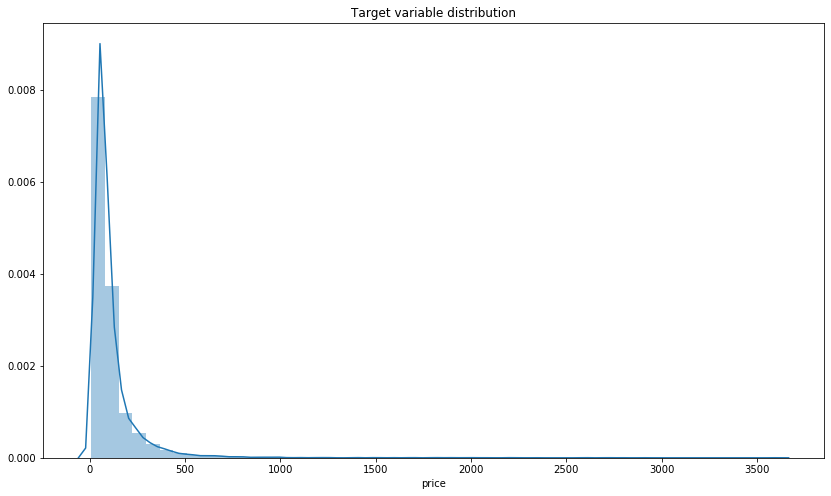

In [12]:
# Target variable distribution
plt.figure(figsize=(14,8))
sns.distplot(bangalore['price'])
plt.title("Target variable distribution")

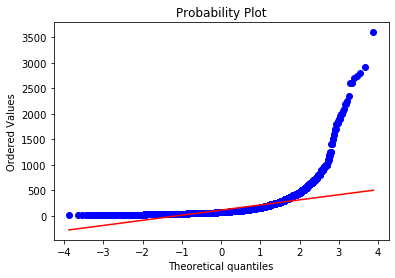

In [13]:
# Probablity plot
fig = plt.figure()
stats.probplot(bangalore['price'], plot=plt)
plt.show()

Text(0.5, 1.0, 'Normalized target distribution')

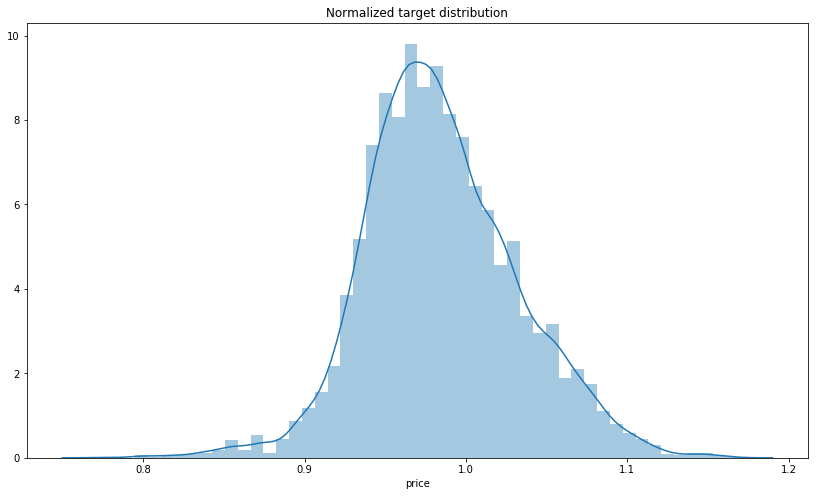

In [14]:
# Normalize target
bangalore['price'] = np.log1p(bangalore['price'])

plt.figure(figsize=(14,8))
sns.distplot(bangalore['price'])
plt.title("Normalized target distribution")

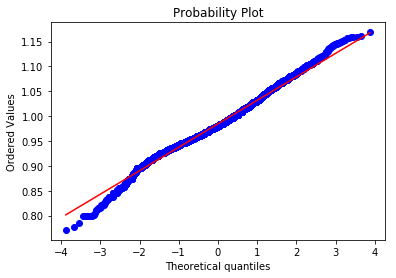

In [15]:
#Probablity plot
fig = plt.figure()
stats.probplot(bangalore['price'], plot=plt)
plt.show()

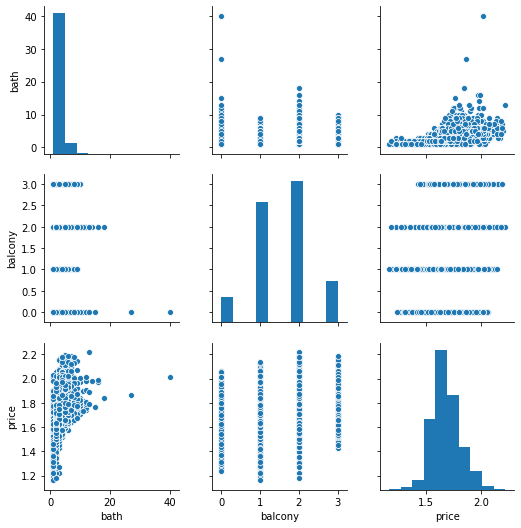

In [17]:
# Barplots and histograms
sns.pairplot(bangalore)

Text(0.5, 1.0, 'Heatmap - Pearson Correlation Coefficients')

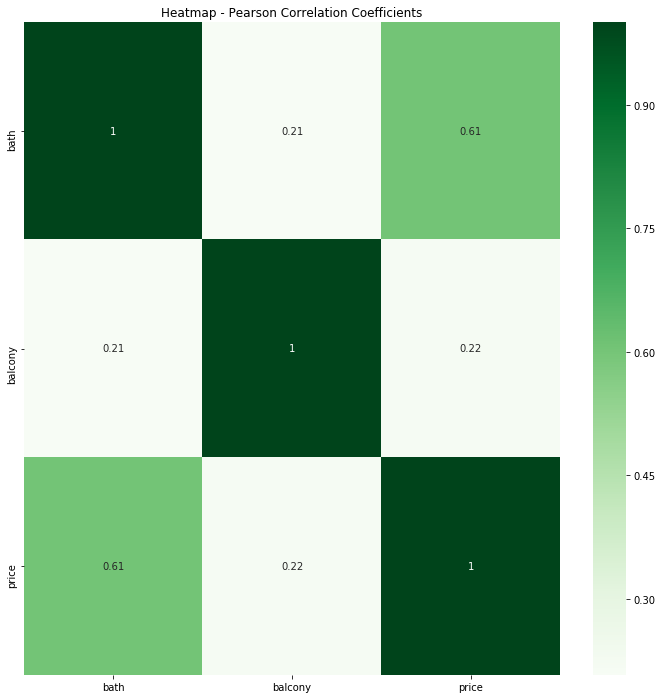

In [16]:
# Pearson correlation coefficients
plt.figure(figsize=(12,12))
sns.heatmap(bangalore.corr(), cmap='Greens', annot=True)
plt.title("Heatmap - Pearson Correlation Coefficients")

In [24]:
# Find the most correlated features
print("Most correlated with the target")
corrs = bangalore.corr()
corrs.sort_values(['price'], ascending=False, inplace=True)
corrs[1:6].price # First five not including target
corrs.price

Most correlated with the target


price      1.000000
bath       0.609368
balcony    0.215570
Name: price, dtype: float64

In [23]:
# House sizes count
var = bangalore.groupby("size").price.count().sort_values(ascending=False)
var

size
2 BHK         5215
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 Bedroom       2
10 BHK           2
11 BHK           2
43 Bedroom       1
13 BHK           1
12 Bedroom       1
14 BHK           1
16 BHK           1
18 Bedroom       1
19 BHK           1
27 BHK           1
Name: price, dtype: int64

Text(0.5, 1, 'Area type count')

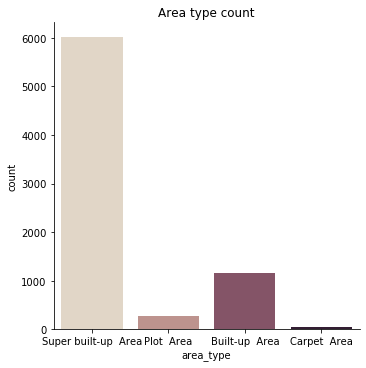

In [20]:
# Area type variable
sns.catplot(x="area_type", kind="count", palette="ch:.25", data=bangalore);
plt.title("Area type count")

Text(0.5, 1, 'Boxplots price and area type')

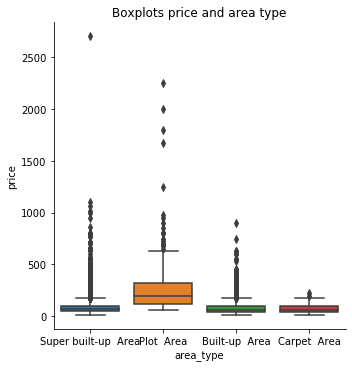

In [21]:
# Boxplots, prices by area types
sns.catplot(x="area_type", y="price", kind="box", data=bangalore)
plt.title("Boxplots price and area type")

In [27]:
# bangalore.describe(include=['float'])
# bangalore.describe(include=['object'])
bangalore.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
area_type,13320,4,Super built-up Area,8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availability,13320,81,Ready To Move,10581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,13320,1305,Whitefield,541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,13320,31,2 BHK,5215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
society,13320,2688,GrrvaGr,5582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_sqft,13320,2117,1200,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bath,13320,NaN,NaN,NaN,2.68881,1.33875,1,2,2,3,40
balcony,13320,NaN,NaN,NaN,1.60338,0.803067,0,1,2,2,3
price,13320,NaN,NaN,NaN,1.67998,0.127879,1.16228,1.59571,1.66591,1.75713,2.218


In [19]:
# Categorical columns
cats = bangalore.select_dtypes(exclude=['number']).columns
cats

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft'],
      dtype='object')

In [20]:
# Use LabelEncoder
from sklearn.preprocessing import LabelEncoder
for cat in cats:
    lbl = LabelEncoder() 
    lbl.fit(list(bangalore[cat].values)) 
    bangalore[cat] = lbl.transform(list(bangalore[cat].values))
    
bangalore.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,3,40,419,13,464,70,2.0,1.0,1.545566
1,2,80,317,19,2439,1288,5.0,3.0,1.757132
2,0,80,1179,16,806,514,2.0,3.0,1.637663


In [30]:
bangalore.dtypes

area_type         int64
availability      int64
location          int64
size              int64
society           int64
total_sqft        int64
bath            float64
balcony         float64
price           float64
dtype: object

In [21]:
# Features
x = bangalore.drop(['price'], axis=1)
x[0:3]

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,3,40,419,13,464,70,2.0,1.0
1,2,80,317,19,2439,1288,5.0,3.0
2,0,80,1179,16,806,514,2.0,3.0


In [24]:
# Normalize
x = preprocessing.StandardScaler().fit(x).transform(x)
x[0:2]

array([[ 0.62046076, -1.67893016, -0.69493672, -0.40202673, -1.06124783,
        -1.09913768, -0.51453799, -0.75137056],
       [-0.25381591,  0.48177474, -0.97438533,  0.94457746,  2.09182609,
         0.83272673,  1.72643617,  1.73917463]])

In [25]:
# Target
y = bangalore['price']
y[0:3]

0    1.545566
1    1.757132
2    1.637663
Name: price, dtype: float64

In [26]:
# Train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

print('Train set:', x_train.shape,  y_train.shape)
print('Test set:', x_test.shape,  y_test.shape)

Train set: (9324, 8) (9324,)
Test set: (3996, 8) (3996,)


In [27]:
# Plot function
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 7
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price')

    plt.show()
    plt.close()

In [91]:
results={}

In [92]:
# Random Forest
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [93]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['Random Forest'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["Random Forest"])

Mean absolute error: 0.04
Residual sum of squares (MSE): 0.00
R2-score: 0.6720


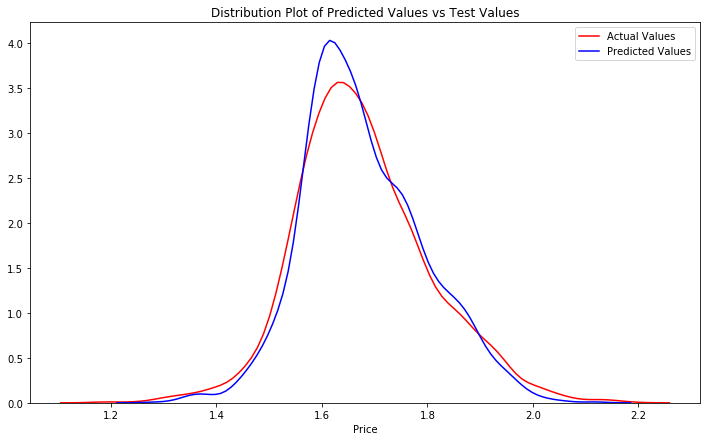

In [94]:
Title = 'Distribution Plot of Predicted Values vs Test Values'
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

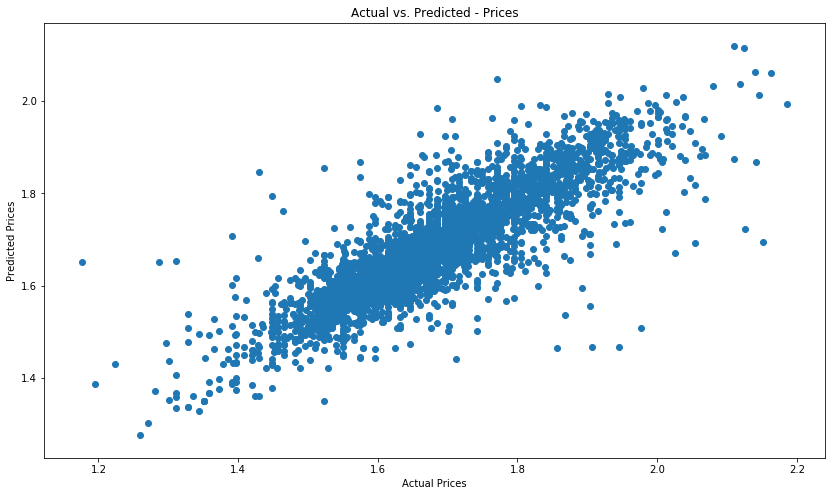

In [95]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [96]:
# XGBoost 
model = XGBRegressor()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

In [97]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['XGB Regressor'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["XGB Regressor"])

Mean absolute error: 0.04
Residual sum of squares (MSE): 0.00
R2-score: 0.7486


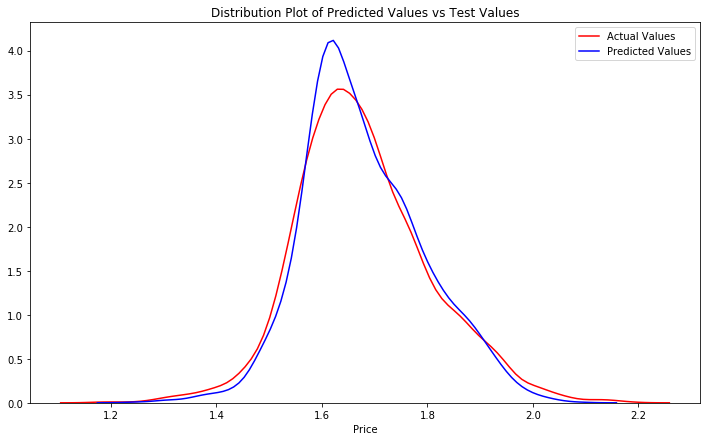

In [98]:
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

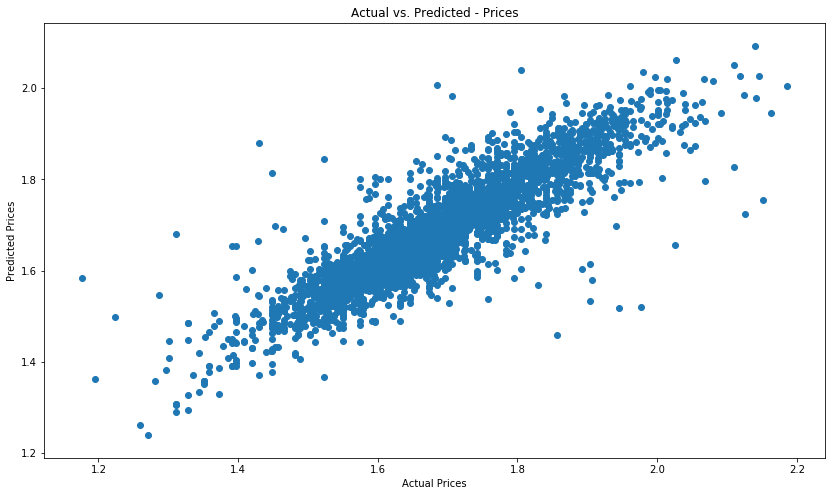

In [99]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [100]:
# Gradient Boosting
model = GradientBoostingRegressor()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

In [101]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['Gradient Boosting'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["Gradient Boosting"])

Mean absolute error: 0.05
Residual sum of squares (MSE): 0.00
R2-score: 0.5955


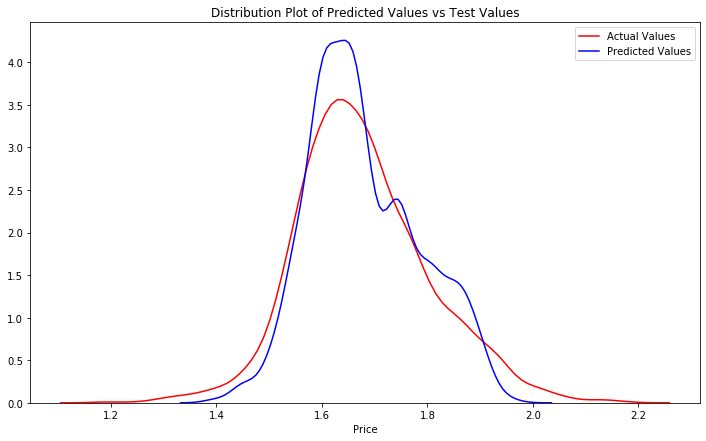

In [102]:
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

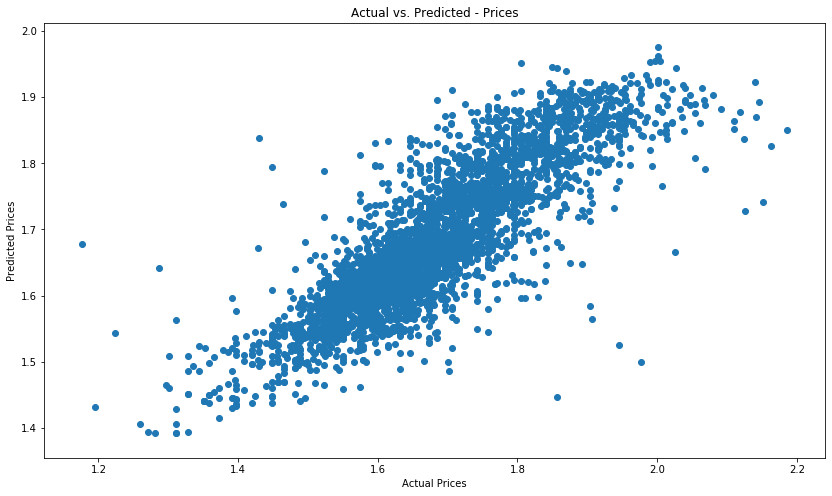

In [103]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [104]:
# Multiple Linear Regression 
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

In [105]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['Multiple Linear Regression'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["Multiple Linear Regression"])

Mean absolute error: 0.07
Residual sum of squares (MSE): 0.01
R2-score: -0.2758


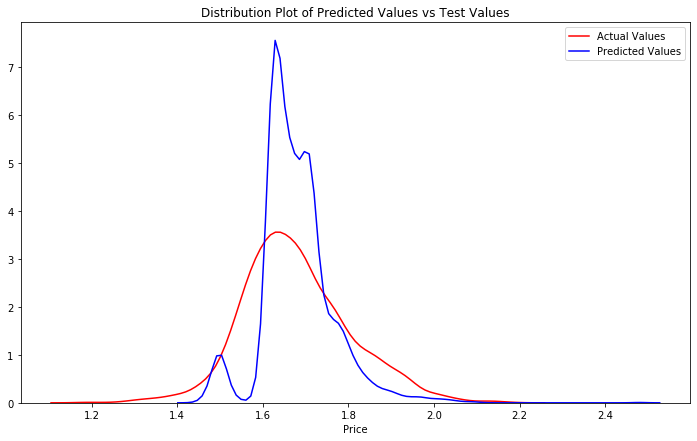

In [106]:
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

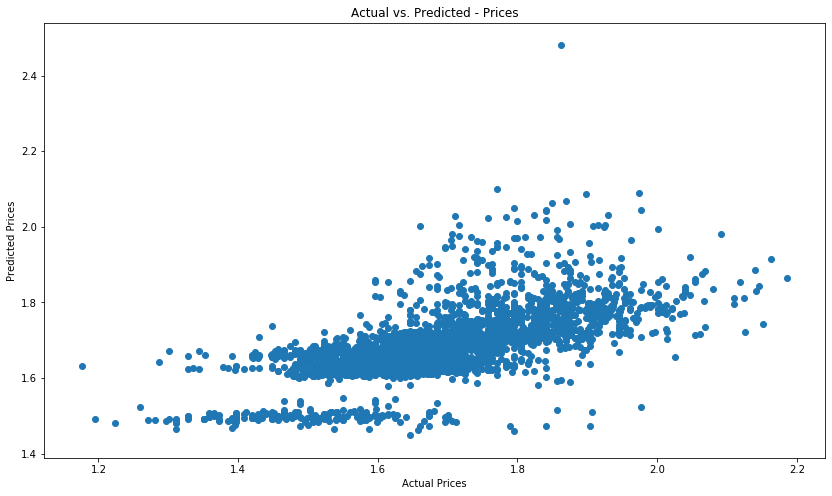

In [107]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [108]:
# Bagging Regressor
model = BaggingRegressor()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

In [109]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['Bagging Regressor'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["Bagging Regressor"])

Mean absolute error: 0.04
Residual sum of squares (MSE): 0.00
R2-score: 0.6702


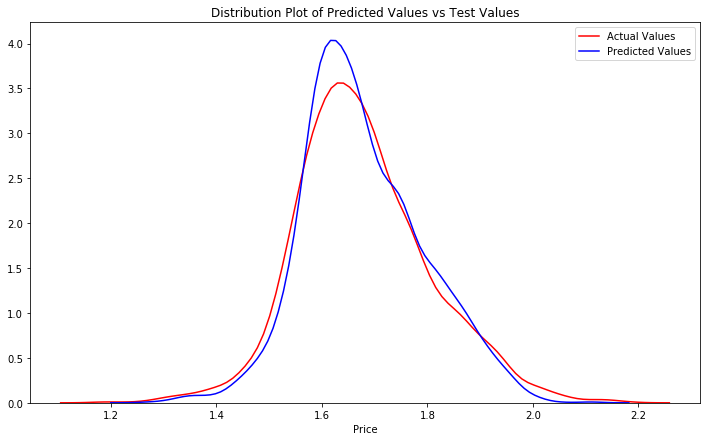

In [110]:
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

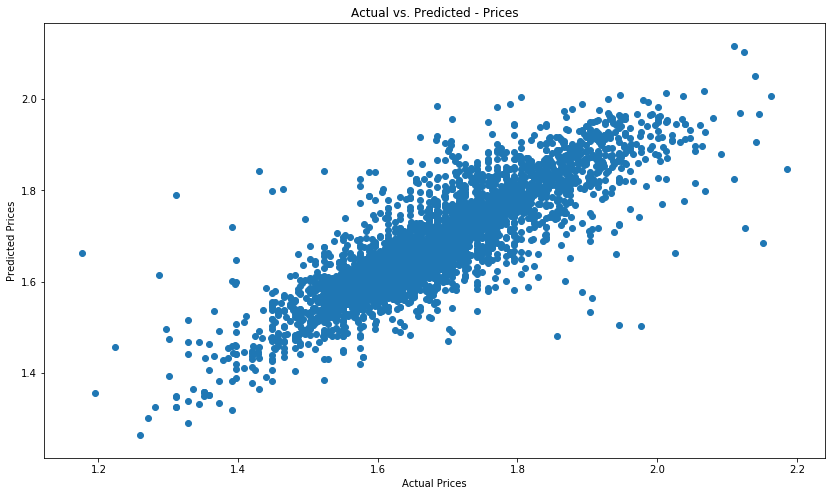

In [111]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [113]:
# Huber Regressor
model = linear_model.HuberRegressor()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

In [114]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test)**2))
results['Huber Regressor'] = r2_score(y_hat, y_test)
print("R2-score: %.4f" % results["Huber Regressor"])

Mean absolute error: 0.07
Residual sum of squares (MSE): 0.01
R2-score: -0.0537


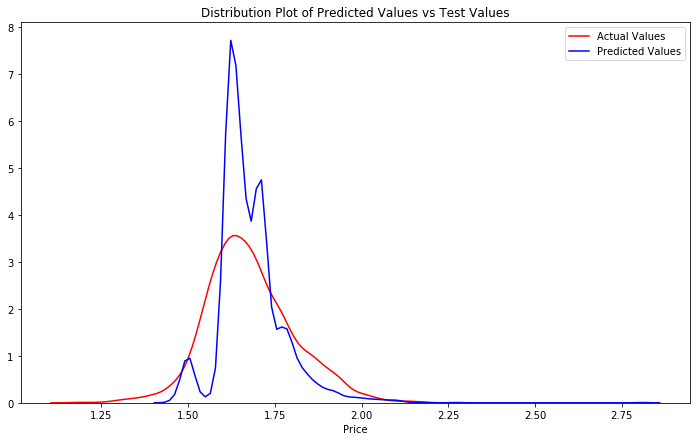

In [115]:
DistributionPlot(y_test, y_hat, "Actual Values", "Predicted Values", Title)

Text(0.5, 1.0, 'Actual vs. Predicted - Prices')

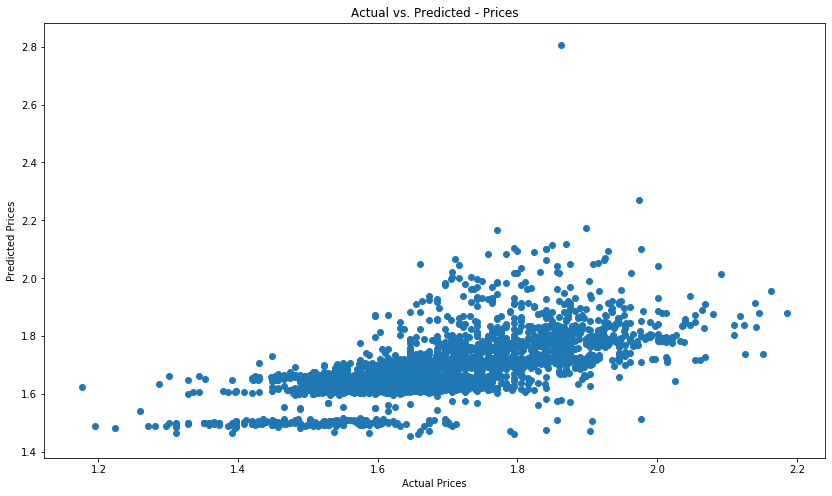

In [116]:
# Compare actual and predicted prices
plt.figure(figsize=(14,8))
plt.scatter(y_test, y_hat)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted - Prices")

In [122]:
# R-squared scores
results

{'Random Forest': 0.6719561335666931,
 'XGB Regressor': 0.7486398437571113,
 'Gradient Boosting': 0.5954665036536342,
 'Multiple Linear Regression': -0.2758193898304151,
 'Bagging Regressor': 0.6702268046116935,
 'Huber Regressor': -0.05374659835746609}

**Thanks for reading!**